# Encoding Emotion in Music via Acoustic Features: A Weakly Supervised Machine Learning Study

Music is a rich medium for emotional expression. From upbeat rhythms to melancholic melodies, audio signals carry subtle cues that humans instinctively interpret as emotional content. Understanding how these features map to perceived emotions is a valuable goal in both music information retrieval and affective computing.

This research explores the effectiveness of supervised machine learning models in predicting user-assigned emotional categories of songs using only audio features. Drawing from user-generated Last.fm tags and Spotify audio features, a dataset was constructed to capture both the semantic and acoustic characteristics of over 24,000 songs.

My research question is: **How accurately can supervised machine learning models predict user-assigned emotional categories of songs using only audio features, and which audio features contribute most to these predictions?**

The primary objective is twofold: (1) evaluate how accurately machine learning models such as K-Nearest Neighbors (KNN), Logistic Regression, Random Forest, and Multi-Layer Perceptron (MLP) can predict song-level emotions; and (2) identify which audio features most strongly influence these predictions. Through model comparison and interpretability analyses, this study seeks to reveal which features consistently contribute to emotion classification across different algorithmic paradigms.

In [ ]:
import os
import sqlite3
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotify_secret import SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET
import pandas as pd

# 1. Data Sets Exploration (Raw Datasets)
To investigate the relationship between audio features and perceived emotional content in music, three primary data sources were used to construct the final dataset:

1. `tags.db`

This SQLite database contains user-generated descriptive tags from Last.fm, including both genre-based and emotion-related labels. Each tag is stored as a single text entry. Example entries include:

- ('classic rock',)
- ('blues',)
- ('instrumental',)
- ('Bonjour ca va',)
- ('Tony Levin',)

The complete table consists of **522,366 rows**, capturing a broad diversity of semantic descriptors used by listeners to annotate music. These tags serve as the foundation for generating emotion labels in this project through semantic mapping and transformer-based classification.

2. `track_metadata.db`

This SQLite table includes metadata for one million unique tracks. Each record contains the following fields:

- Track ID
- Title
- Album ID
- Album Name
- Artist ID
- MusicBrainz ID
- Artist Name
- Duration (in seconds)
- Artist familiarity
- Artist hotness
- Year of release
- Song ID
- Track number
- Genre cluster (if available)

Example entry:

```text
('TRMMMYQ128F932D901', 'Silent Night', 'SOQMMHC12AB0180CB8', 'Monster Ballads X-Mas',
 'ARYZTJS1187B98C555', '357ff05d-848a-44cf-b608-cb34b5701ae5', 'Faster Pussy cat',
 252.05, 0.6498, 0.3940, 2003, 7032331, -1, 0)
```
This metadata enables track-level identification, filtering, and alignment with both tags and audio features.

3. `Kaggle_Spotify_Audio_Features.sqlite`
This database contains detailed audio analysis data for over 8.7 million Spotify tracks. Each entry includes the following features:
- acousticness
- danceability
- energy
- instrumentalness
- key
- liveness
- loudness
- mode
- speechiness
- tempo
- time_signature
- valence
Each track is also identified by a unique Spotify ID and includes metadata such as duration and analysis URL.

Example entry:

```text
('2jKoVlU7VAmExKJ1Jh3w9P', 0.180, ..., 0.787)
```

#### `tags.db`

In [39]:
import sqlite3

with sqlite3.connect('raw_datasets/tags.db') as conn:
    cursor = conn.cursor()
    
    # Select all columns and limit to 10 rows
    cursor.execute("SELECT * FROM tags LIMIT 10;")
    data = cursor.fetchall()
    
    for row in data:
        print(row)  # Print all columns in each row


    print('\n------ Checking the number of rows in the table ------')
    cursor.execute("SELECT COUNT(*) FROM tags;")
    data = cursor.fetchall()
    print(data[0][0])

('classic rock',)
('Progressive rock',)
('blues',)
('memphis slim',)
('pop',)
('70s',)
('Middle of the road',)
('Bonjour ca va',)
('Tony Levin',)
('instrumental',)

------ Checking the number of rows in the table ------
522366


In [ ]:
cursor.execute("PRAGMA table_info(tags);")
for col in cursor.fetchall():
    print(col[1])  # col[1] contains the column name

conn.close()


tag


#### `track_metadata.db`

In [38]:
import sqlite3

with sqlite3.connect('raw_datasets/track_metadata.db') as conn:
    cursor = conn.cursor()
    
    # Select all columns, limit to first 10 rows
    cursor.execute("SELECT * FROM songs LIMIT 10;")
    data = cursor.fetchall()
    
    for row in data:
        print(row)  # Each row is a tuple of all columns

    print('\n------ Checking the number of rows in the table ------')
    cursor.execute("SELECT COUNT(*) FROM songs;")
    data = cursor.fetchall()
    print(data[0][0])


('TRMMMYQ128F932D901', 'Silent Night', 'SOQMMHC12AB0180CB8', 'Monster Ballads X-Mas', 'ARYZTJS1187B98C555', '357ff05d-848a-44cf-b608-cb34b5701ae5', 'Faster Pussy cat', 252.05506, 0.649822100201, 0.394031892714, 2003, 7032331, -1, 0)
('TRMMMKD128F425225D', 'Tanssi vaan', 'SOVFVAK12A8C1350D9', 'Karkuteillä', 'ARMVN3U1187FB3A1EB', '8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9', 'Karkkiautomaatti', 156.55138, 0.439603966677, 0.356992107756, 1995, 1514808, -1, 0)
('TRMMMRX128F93187D9', 'No One Could Ever', 'SOGTUKN12AB017F4F1', 'Butter', 'ARGEKB01187FB50750', '3d403d44-36ce-465c-ad43-ae877e65adc4', 'Hudson Mohawke', 138.97098, 0.643680572058, 0.437503836595, 2006, 6945353, -1, 0)
('TRMMMCH128F425532C', 'Si Vos Querés', 'SOBNYVR12A8C13558C', 'De Culo', 'ARNWYLR1187B9B2F9C', '12be7648-7094-495f-90e6-df4189d68615', 'Yerba Brava', 145.05751, 0.448501159656, 0.372349068517, 2003, 2168257, -1, 0)
('TRMMMWA128F426B589', 'Tangle Of Aspens', 'SOHSBXH12A8C13B0DF', 'Rene Ablaze Presents Winter Sessions', 'ARE

In [20]:
cursor.execute("PRAGMA table_info(songs);")
for col in cursor.fetchall():
    print(col[1])

conn.close()

track_id
title
song_id
release
artist_id
artist_mbid
artist_name
duration
artist_familiarity
artist_hotttnesss
year
track_7digitalid
shs_perf
shs_work


### `Kaggle_Spotify_Audio_Features.sqlite`

In [43]:
import sqlite3

with sqlite3.connect('raw_datasets/Kaggle_Spotify_Audio_Features.sqlite') as conn:
    cursor = conn.cursor()

    # List all table names in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    for table in tables:
        print(table[0])


albums
artists
audio_features
genres
r_albums_artists
r_albums_tracks
r_artist_genre
r_track_artist
tracks


In [ ]:
with sqlite3.connect('raw_datasets/Kaggle_Spotify_Audio_Features.sqlite') as conn:
    cursor = conn.cursor()
    
    # Show all columns and first 10 rows of the 'tracks' table
    cursor.execute("SELECT * FROM audio_features LIMIT 10;")
    data = cursor.fetchall()
    
    for row in data:
        print(row)
    
    print('\n------ Checking the number of rows in the table ------')
    cursor.execute("SELECT COUNT(*) FROM audio_features;")
    data = cursor.fetchall()
    print(data[0][0])

('2jKoVlU7VAmExKJ1Jh3w9P', 0.18000000715255737, 'https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P', 0.8930000066757202, 219160, 0.5139999985694885, 0.0, 11, 0.05959999933838844, -5.079999923706055, 1, 0.28299999237060547, 95.8479995727539, 4, 0.7870000004768372)
('4JYUDRtPZuVNi7FAnbHyux', 0.2720000147819519, 'https://api.spotify.com/v1/audio-analysis/4JYUDRtPZuVNi7FAnbHyux', 0.5199999809265137, 302013, 0.847000002861023, 0.0, 9, 0.32499998807907104, -5.300000190734863, 1, 0.4269999861717224, 177.37100219726562, 4, 0.7990000247955322)
('6YjKAkDYmlasMqYw73iB0w', 0.07829999923706055, 'https://api.spotify.com/v1/audio-analysis/6YjKAkDYmlasMqYw73iB0w', 0.9179999828338623, 288200, 0.5860000252723694, 0.0, 1, 0.14499999582767487, -2.890000104904175, 1, 0.13300000131130219, 95.51699829101562, 4, 0.7789999842643738)
('2YlvHjDb4Tyxl4A1IcDhAe', 0.5839999914169312, 'https://api.spotify.com/v1/audio-analysis/2YlvHjDb4Tyxl4A1IcDhAe', 0.8769999742507935, 243013, 0.6809999942779541, 0.

In [34]:
cursor.execute("PRAGMA table_info(audio_features);")
for col in cursor.fetchall():
    print(col[1])  # column name

conn.close()

id
acousticness
analysis_url
danceability
duration
energy
instrumentalness
key
liveness
loudness
mode
speechiness
tempo
time_signature
valence


# 2. Transformer Model: From Tags to Emotions
### Connect to `tags.db` and Extract the Matching Tags' ID based on the Emotional Mapping

Join `tags` table with `tids` table (`tids` contains track ids used in <b>Million Songs</b> database, and they are different from Spotify API's track ids.

To derive emotion categories from user-generated tags in `tags.db`, I applied a semantic classification approach using a transformer-based language model. Many of the Last.fm tags are open-ended, descriptive terms such as genres (e.g., “classic rock”), subjective descriptors (e.g., “uplifting”), or artist names. To make these tags usable for supervised learning, we mapped them to six basic emotions:

- **joy**
- **surprise**
- **anger**
- **sadness**
- **fear**
- **disgust**

This was accomplished by feeding each tag into a fine-tuned DistilRoBERTa model trained to associate short texts with one of the above emotion categories. Tags were individually classified, and their corresponding emotion labels were saved alongside the associated track ID in a new file: `lastfmid_emotion.xlsx`.

An excerpt from the output format is shown below:

| emotion   | track_id             |
|-----------|----------------------|
| joy       | TRCCCBJ128F4286E6F   |
| joy       | TRCCJTD12903CB62E6   |
| joy       | TRCCJKN128F426E04D   |

The final label distribution was as follows:

- **joy**: 291,626
- **sadness**: 146,194
- **anger**: 40,496
- **disgust**: 26,234
- **fear**: 20,377
- **surprise**: 22,549

This labeling step transformed noisy, heterogeneous tag data into a unified emotion classification scheme, enabling downstream supervised learning using audio features.


In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

In [ ]:
def get_emotion(tag):
    result = classifier(tag)
    highest_score = max(result[0], key=lambda x: x['score'])
    if highest_score['score'] > 0.8 and highest_score['label'] != 'neutral':
        return highest_score['label']
    return None

get_emotion("happy")

'joy'

In [ ]:
import sqlite3

tag_to_track_ids = {}
batch_size = 1000
offset = 0

with sqlite3.connect("raw_datasets/tags.db") as conn:
    cursor = conn.cursor()

    while True:
        sql = f"""
        SELECT tags.tag, tids.tid
        FROM tid_tag
        JOIN tids ON tids.ROWID = tid_tag.tid
        JOIN tags ON tid_tag.tag = tags.ROWID
        LIMIT {batch_size} OFFSET {offset}
        """
        cursor.execute(sql)
        data = cursor.fetchall()

        if not data:
            break

        for tag, tid in data:
            emotion = get_emotion(tag)
            if emotion:
                tag_to_track_ids.setdefault(emotion, []).append(tid)

        offset += batch_size
        print({k: len(v) for k, v in tag_to_track_ids.items()})

        # store the results in a DataFrame and save to Excel
        df = pd.DataFrame([
            {"emotion": emotion, "track_id": tid}
            for emotion, tids in tag_to_track_ids.items()
            for tid in tids
        ])
        df.to_excel("transformer_datasets/lastfmid_emotion.xlsx", index=False)


{'joy': 38, 'surprise': 3, 'anger': 2, 'sadness': 19, 'fear': 2, 'disgust': 5}
{'joy': 76, 'surprise': 3, 'anger': 8, 'sadness': 38, 'fear': 3, 'disgust': 9}
{'joy': 113, 'surprise': 3, 'anger': 14, 'sadness': 47, 'fear': 9, 'disgust': 10}
{'joy': 133, 'surprise': 4, 'anger': 16, 'sadness': 63, 'fear': 12, 'disgust': 13}
{'joy': 169, 'surprise': 7, 'anger': 21, 'sadness': 82, 'fear': 13, 'disgust': 17}
{'joy': 193, 'surprise': 8, 'anger': 23, 'sadness': 97, 'fear': 13, 'disgust': 20}
{'joy': 225, 'surprise': 11, 'anger': 26, 'sadness': 112, 'fear': 19, 'disgust': 27}
{'joy': 257, 'surprise': 15, 'anger': 30, 'sadness': 124, 'fear': 20, 'disgust': 32}
{'joy': 288, 'surprise': 18, 'anger': 34, 'sadness': 140, 'fear': 24, 'disgust': 34}
{'joy': 322, 'surprise': 19, 'anger': 39, 'sadness': 154, 'fear': 26, 'disgust': 37}
{'joy': 354, 'surprise': 21, 'anger': 46, 'sadness': 168, 'fear': 28, 'disgust': 38}
{'joy': 384, 'surprise': 24, 'anger': 50, 'sadness': 184, 'fear': 29, 'disgust': 39}
{

In [6]:
lastfmid_emotion = pd.read_excel('transformer_datasets/lastfmid_emotion.xlsx')
lastfmid_emotion.head()

,emotion,track_id
0,joy,TRCCCBJ128F4286E6F
1,joy,TRCCJTD12903CB62E6
2,joy,TRCCJKN128F426E04D
3,joy,TRCCHEP128F932DE5F
4,joy,TRCCXER12903CA558C


# 3. Last.fm ID to Matching Tracks' Name
After generating emotion labels for Last.fm track IDs using a transformer-based classifier, I retrieved the corresponding song metadata from the `songs` table of the Million Song Dataset. This table was originally loaded from `track_metadata.db` and includes metadata such as track name, artist name, album, and year of release.

Using the labeled track IDs obtained from `lastfmid_emotion.xlsx`, we performed a join operation to retrieve the following fields:

- **Last.fm Track ID**
- **Track Title**
- **Artist Name**
- **Emotion Label**

This matching process resulted in a final dataset containing **297,730 unique songs**, each annotated with one of six basic emotion categories. The output was saved in `matched_track_info.csv` for downstream integration with audio features.

The distribution of labeled songs after metadata matching is as follows:

- **joy**: 123,053
- **sadness**: 85,313
- **anger**: 30,165
- **disgust**: 22,692
- **surprise**: 19,569
- **fear**: 16,938

This step ensured that all emotion-labeled tracks were associated with human-readable identifiers (song title and artist), forming a bridge between abstract semantic labels and concrete audio representations.


In [23]:
matched_rows = []

BATCH_SIZE = 500

with sqlite3.connect("raw_datasets/track_metadata.db") as conn:
    cursor = conn.cursor()

    track_emotion_pairs = list(zip(lastfmid_emotion['track_id'], lastfmid_emotion['emotion']))

    for i in range(0, len(track_emotion_pairs), BATCH_SIZE):
        batch = track_emotion_pairs[i:i + BATCH_SIZE]
        track_ids = [pair[0] for pair in batch]

        sql = f"""
        SELECT track_id, title, artist_name
        FROM songs
        WHERE track_id IN ({','.join(['?'] * len(track_ids))})
        """
        cursor.execute(sql, track_ids)
        results = cursor.fetchall()

        trackid_to_emotion = dict(batch)

        for track_id, title, artist in results:
            matched_rows.append({
                "track_id": track_id,
                "emotion": trackid_to_emotion.get(track_id),
                "title": title,
                "artist": artist
            })

df_matched = pd.DataFrame(matched_rows)
df_matched.to_csv("matched_track_info.csv", index=False)

print(f"Matched {len(df_matched)} songs and saved to matched_track_info.csv")
emotion_counts = df_matched['emotion'].value_counts()
print(emotion_counts)


Matched 297730 songs and saved to matched_track_info.csv
emotion
joy         123053
sadness      85313
anger        30165
disgust      22692
surprise     19569
fear         16938
Name: count, dtype: int64


## Spotify API
Before running the following code, make sure to enter your `SPOTIFY_CLIENT_ID` and `SPOTIPY_CLIENT_SECRET` under `spotify_secret.py` file

In [6]:
os.environ['SPOTIPY_CLIENT_ID'] = SPOTIPY_CLIENT_ID
os.environ['SPOTIPY_CLIENT_SECRET'] = SPOTIPY_CLIENT_SECRET

auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

### Search Spotify track ids by artists and titles

In [ ]:
import os
import time
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from requests.exceptions import ReadTimeout

# Input file from previous step
df_matched = pd.read_csv("matched_track_info.csv")
seen_titles = set()

# Output file
OUTPUT_FILE = "spotifyid_emotion.csv"

# Target counts per emotion
target_counts = {
    "sadness": 16000,
    "joy": 16000,
    "anger": 16000,
    "disgust": 16000,
    "surprise": 16000,
    "fear": 16000
}

# Load already processed data
if os.path.exists(OUTPUT_FILE):
    spotifyid_emotion_df = pd.read_csv(OUTPUT_FILE)
    processed_track_ids = set(spotifyid_emotion_df["spotify_id"])
    processed_emotion_counts = spotifyid_emotion_df["emotion"].value_counts().to_dict()
else:
    spotifyid_emotion_df = pd.DataFrame()
    processed_track_ids = set()
    processed_emotion_counts = {}

# Filter only emotions that still need more tracks
emotions_to_process = {
    emotion: count for emotion, count in target_counts.items()
    if processed_emotion_counts.get(emotion, 0) < count
}

if not emotions_to_process:
    print("All emotions are complete.")
    exit()

print("Still need data for:", emotions_to_process)

# Spotify API credentials
SPOTIFY_CREDENTIALS = [
    {"client_id": "SPOTIPY_CLIENT_ID", "client_secret": "SPOTIPY_CLIENT_SECRET"},
]
current_cred_index = 0

def set_spotify_client(index):
    global sp, current_cred_index
    creds = SPOTIFY_CREDENTIALS[index]
    os.environ["SPOTIPY_CLIENT_ID"] = creds["client_id"]
    os.environ["SPOTIPY_CLIENT_SECRET"] = creds["client_secret"]
    auth_manager = SpotifyClientCredentials()
    sp = spotipy.Spotify(auth_manager=auth_manager, requests_timeout=10, retries=5)
    print(f"Using Spotify API Credential {index + 1}")

set_spotify_client(current_cred_index)

def clean_query(title, artist):
    max_length = 250
    artist = artist.split(";")[0].strip()
    query = f"track:{title} artist:{artist}"
    if len(query) > max_length:
        title = title[:max_length - len(f"track: artist:{artist}") - 5] + "..."
        query = f"track:{title} artist:{artist}"
    return query

def fetch_track_id(title, artist, max_retries=3):
    global current_cred_index
    query = clean_query(title, artist)

    for attempt in range(max_retries):
        try:
            results = sp.search(q=query, type="track", limit=1)
            if results['tracks']['items']:
                return results['tracks']['items'][0]['id']
            else:
                return None
        except spotipy.SpotifyException as e:
            if "rate limit" in str(e).lower():
                print("Rate limit hit, switching credentials.")
                current_cred_index = (current_cred_index + 1) % len(SPOTIFY_CREDENTIALS)
                set_spotify_client(current_cred_index)
                time.sleep(5)
            else:
                print(f"Spotify error: {e}")
                time.sleep(2)
        except ReadTimeout:
            print(f"Timeout occurred, retrying ({attempt + 1}/{max_retries})...")
            time.sleep(5)
    return None

# Processing
final_rows = []
for _, row in df_matched.iterrows():
    emotion = row["emotion"]
    title = row["title"]
    artist = row["artist"]

    if emotion not in emotions_to_process:
        continue

    current_count = processed_emotion_counts.get(emotion, 0)
    if current_count >= target_counts[emotion]:
        continue

    if title in seen_titles:
        continue

    track_id = fetch_track_id(title, artist)
    if not track_id or track_id in processed_track_ids:
        continue

    final_rows.append({
        "spotify_id": track_id,
        "emotion": emotion,
        "title": title,
        "artist": artist
    })

    seen_titles.add(title)
    processed_track_ids.add(track_id)
    processed_emotion_counts[emotion] = current_count + 1

    if len(final_rows) % 100 == 0:
        df = pd.DataFrame(final_rows)
        df.to_csv(OUTPUT_FILE, mode="a", header=not os.path.exists(OUTPUT_FILE), index=False)
        print(f"Saved {len(final_rows)} new entries.")
        final_rows = []

    time.sleep(0.5)

# Final save
if final_rows:
    df = pd.DataFrame(final_rows)
    df.to_csv(OUTPUT_FILE, mode="a", header=not os.path.exists(OUTPUT_FILE), index=False)
    print(f"Final batch saved with {len(final_rows)} entries.")

print("All tracks processed.")

In [177]:
import pandas as pd

# check the amount of each emotion in the final file
spotifyid_emotion_multi = pd.read_csv("spotifyid_emotion_multilabel.csv")
emotion_counts = spotifyid_emotion_multi['emotion'].value_counts()
print(emotion_counts)

emotion
joy         50843
sadness     39985
anger       22186
disgust     16821
surprise    14344
fear        12752
Name: count, dtype: int64


/var/folders/jw/cc3wc0f13632_rh4jzxbdz3w0000gn/T/ipykernel_96064/464658296.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=emotion_df, x="Emotion", y="Count", palette="Set2")


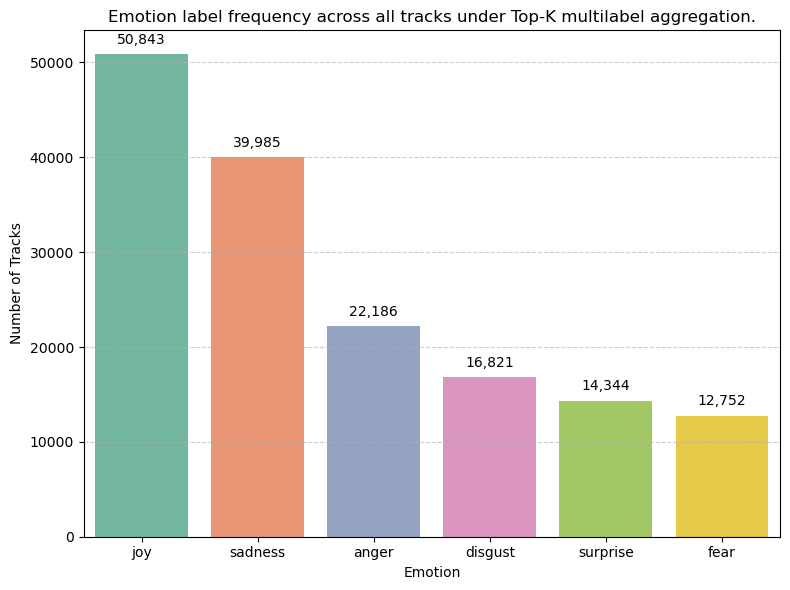

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Emotion frequency data
emotion_counts = {
    "joy": 50843,
    "sadness": 39985,
    "anger": 22186,
    "disgust": 16821,
    "surprise": 14344,
    "fear": 12752
}

# Convert to DataFrame
emotion_df = pd.DataFrame.from_dict(emotion_counts, orient="index", columns=["Count"]).reset_index()
emotion_df.columns = ["Emotion", "Count"]

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=emotion_df, x="Emotion", y="Count", palette="Set2")

# Add value labels
for i, row in emotion_df.iterrows():
    ax.text(i, row["Count"] + 800, f"{row['Count']:,}", ha='center', va='bottom', fontsize=10)

# Final formatting
plt.title("Emotion label frequency across all tracks under Top-K multilabel aggregation.", fontsize=12)
plt.ylabel("Number of Tracks")
plt.xlabel("Emotion")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [178]:
spotifyid_emotion_single = pd.read_csv("spotifyid_emotion_singlelabel.csv")
emotion_counts = spotifyid_emotion_single['emotion'].value_counts()
print(emotion_counts)

emotion
joy         22000
sadness     16000
disgust     14530
surprise    14251
anger       13613
fear        12843
Name: count, dtype: int64


## Read table that contains Spotify track ids and audio features from a CSV file

In [ ]:
conn = sqlite3.connect("spotify.sqlite")
sql = f"""
    SELECT tracks.id AS track_id, features.acousticness,
    features.danceability, features.energy, features.instrumentalness, features.key,
    features.liveness, features.loudness, features.mode, features.speechiness, features.tempo, features.time_signature, features.valence
    FROM audio_features features
    JOIN tracks ON features.id = tracks.audio_feature_id
    """
df = pd.read_sql_query(sql, conn)
conn.close()

In [162]:
audio_feature_df = pd.read_csv('raw_datasets/spotify_tracks_with_features.csv')
audio_feature_df.head()

,track_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,0.893,0.514,0.000000,11,0.0596,-5.080,1,0.283,95.848000,4,0.787
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,0.520,0.847,0.000000,9,0.3250,-5.300,1,0.427,177.371002,4,0.799
2,6YjKAkDYmlasMqYw73iB0w,0.0783,0.918,0.586,0.000000,1,0.1450,-2.890,1,0.133,95.516998,4,0.779
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,0.877,0.681,0.000000,1,0.1190,-6.277,0,0.259,94.834999,4,0.839
4,3UOuBNEin5peSRqdzvlnWM,0.1700,0.814,0.781,0.000518,11,0.0520,-3.330,1,0.233,93.445000,4,0.536


## Join two tables by track ids to link emotions to audio features

In [ ]:
merged_df_multi = pd.merge(audio_feature_df, spotifyid_emotion_multi, on="track_id", how="inner")
merged_df_multi.to_csv("spotify_emotion_feature_multi.csv", index=False)
merged_df_multi.head()

,track_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,emotion,title,artist
0,2g8HN35AnVGIk7B8yMucww,0.430,0.780,0.575,0.0,9,0.1430,-7.247,0,0.273,84.491997,4,0.773,fear,Big Poppa,The Notorious B.I.G.
1,2g8HN35AnVGIk7B8yMucww,0.430,0.780,0.575,0.0,9,0.1430,-7.247,0,0.273,84.491997,4,0.773,sadness,Big Poppa,The Notorious B.I.G.
2,2g8HN35AnVGIk7B8yMucww,0.430,0.780,0.575,0.0,9,0.1430,-7.247,0,0.273,84.491997,4,0.773,disgust,Big Poppa,The Notorious B.I.G.
3,2g8HN35AnVGIk7B8yMucww,0.430,0.780,0.575,0.0,9,0.1430,-7.247,0,0.273,84.491997,4,0.773,anger,Big Poppa,The Notorious B.I.G.
4,4E5IFAXCob6QqZaJMTw5YN,0.263,0.769,0.818,0.0,6,0.0787,-1.385,0,0.192,88.016998,4,0.918,sadness,Poppin' Them Thangs,G-Unit


In [ ]:
merged_df_multi['emotion'].value_counts()

emotion
joy         27038
sadness     21559
anger       11698
disgust      8908
surprise     7487
fear         6260
Name: count, dtype: int64

In [179]:
merged_df_single = pd.merge(audio_feature_df, spotifyid_emotion_single, on="track_id", how="inner")
merged_df_single.to_csv("spotify_emotion_feature_single.csv", index=False)
merged_df_single.head()

,track_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,emotion,title,artist
0,2g8HN35AnVGIk7B8yMucww,0.4300,0.780,0.575,0.000000,9,0.1430,-7.247,0,0.2730,84.491997,4,0.773,fear,Big Poppa,The Notorious B.I.G.
1,4E5IFAXCob6QqZaJMTw5YN,0.2630,0.769,0.818,0.000000,6,0.0787,-1.385,0,0.1920,88.016998,4,0.918,sadness,Poppin' Them Thangs,G-Unit
2,3jP6KQgQaL2JFEvBW6rELJ,0.5580,0.781,0.757,0.000093,1,0.1020,-5.500,1,0.1460,98.938004,4,0.901,sadness,Survival Tactics,Styles Of Beyond
3,2I9foKseoFQh07p6sD2voE,0.0153,0.653,0.826,0.001460,6,0.1310,-2.930,0,0.3540,108.519997,5,0.416,fear,Many Men (Wish Death),50 Cent
4,5EwQxd2XGjp1BUZT2iHhEj,0.9940,0.392,0.128,0.153000,2,0.0983,-15.220,1,0.0378,126.727997,3,0.226,fear,You'll Never Know,Dick Haymes


In [180]:
merged_df_single['emotion'].value_counts()

emotion
joy         11183
sadness      8333
disgust      7719
surprise     7467
anger        6923
fear         6311
Name: count, dtype: int64

In [11]:
import pandas as pd

df = pd.read_csv("spotify_emotion_feature_multi.csv")

# Define the audio feature columns
feature_cols = [
    "acousticness", "danceability", "energy", "instrumentalness",
    "key", "liveness", "loudness", "mode", "speechiness",
    "tempo", "time_signature", "valence"
]

# Compute descriptive statistics
feature_stats = df[feature_cols].describe().T

# Add median column
feature_stats["median"] = df[feature_cols].median()

# Reorder columns
feature_stats = feature_stats[["count", "mean", "std", "min", "25%", "median", "50%", "75%", "max"]]

# Round for readability
feature_stats = feature_stats.round(3)

# Display table
print(feature_stats)

# Optional: Export to CSV
feature_stats.to_csv("Presentation/summary_audio_feature_stats.csv")

                    count     mean     std     min     25%   median      50%  \
acousticness      82950.0    0.240   0.304   0.000   0.004    0.079    0.079   
danceability      82950.0    0.521   0.175   0.000   0.397    0.525    0.525   
energy            82950.0    0.653   0.249   0.000   0.476    0.696    0.696   
instrumentalness  82950.0    0.155   0.290   0.000   0.000    0.001    0.001   
key               82950.0    5.328   3.562   0.000   2.000    5.000    5.000   
liveness          82950.0    0.196   0.160   0.009   0.095    0.130    0.130   
loudness          82950.0   -8.664   4.338 -50.014 -10.943   -7.779   -7.779   
mode              82950.0    0.653   0.476   0.000   0.000    1.000    1.000   
speechiness       82950.0    0.074   0.079   0.000   0.034    0.045    0.045   
tempo             82950.0  122.379  29.479   0.000  99.848  120.110  120.110   
time_signature    82950.0    3.905   0.393   0.000   4.000    4.000    4.000   
valence           82950.0    0.479   0.2